In [4]:
# Ignore warnings (just for clarity of tutorial)
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster, cut_tree, linkage
from scipy.spatial.distance import pdist

from gimmemotifs.maelstrom import run_maelstrom
from gimmemotifs import __version__

print("GimmeMotifs version:", __version__)

GimmeMotifs version: 0.12.0+123.g924be56.dirty


# Load data

Read the file with H3K27ac read counts. This file is based on H3K27ac read counts from 193 experiments. The regions were determined by a union of peaks of 69 DNase I experiments. This data file can also be found at Zenodo: [10.5281/zenodo.1488669](https://doi.org/10.5281/zenodo.1488669).

Direct download link: https://zenodo.org/record/1488669/files/H3K27ac.table.hg38.tsv.gz?download=1

In [2]:
df = pd.read_table("data/H3K27ac.table.hg38.tsv.gz", index_col=0)
print("(n_regions, n_experiments) =", df.shape)

(n_regions, n_experiments) = (254547, 193)


# Update the region size

The regions in which the H3K27ac reads were counted are 2kbp. However, to perform a motif analysis we will use 200bp.

In [3]:
# Set region size to 200
w = 200
new_index = pd.DataFrame(df.index.to_series().str.split('[:-]', expand=True))
new_index.columns = ["chrom", "start", "end"]
new_index["start"] = ((new_index["start"].astype(int) + new_index["end"].astype(int)) / 2 - w / 2).astype(int)
new_index["end"] = new_index["start"] + w
new_index["loc"] = new_index["chrom"] + ":" + new_index["start"].astype(str) + "-" + new_index["end"].astype("str")
df["loc"] = new_index["loc"]
df = df.set_index("loc")

# Normalization

In [4]:
# Log-transform count data
df = np.log2(df + 1)

# Normalize
df_norm = df[:]
df_norm[:] = scale(df, axis=0)

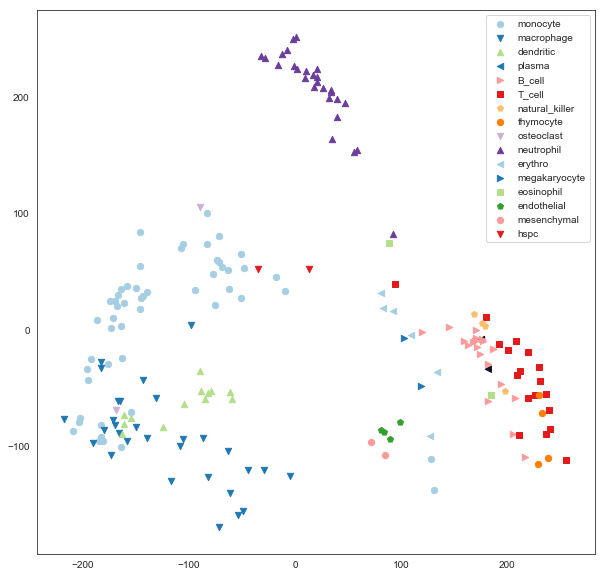

In [5]:
pca = PCA(n_components=10).fit_transform(df_norm.T)
pca = pd.DataFrame(pca, columns=["pc{}".format(i + 1) for i in range(10)], index=df_norm.columns)

cell_types =  [
               "monocyte", 
               "macrophage", 
               "dendritic", 
               "plasma", 
               "B_cell", 
               "T_cell", 
               "natural_killer",
               "thymocyte",
               "osteoclast", 
               "neutrophil", 
               "erythro", 
               "megakaryocyte", 
               "eosinophil", 
               "endothelial", 
               "mesenchymal", 
               "hspc"
              ]

pca["cell_type"] = ""
for cell_type in cell_types:
    pca.loc[pca.index.str.contains(cell_type, case=False),"cell_type"] = cell_type

markers = ('o', 'v', '^', '<', '>',  's', 'p', '*')

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(10,10))
for i,cell_type in enumerate(cell_types):
    df_plot = pca[pca["cell_type"] == cell_type]
    #print cell_type, df_plot.shape
    plt.scatter(df_plot["pc1"], df_plot["pc2"],c=pal[i% len(pal)],s=40,
               marker=markers[i % (len(markers) - 1)])
    #df_pca[df_pca["cell_type"] == cell_type].plot(kind='scatter', x='PC1', y='PC2', s=50);
plt.legend(cell_types)
plt.savefig("out/pca_plot.svg")

# Remove treated samples and average replicates.

In [6]:
cols = df_norm.columns

# Remove all treated samples
cols = cols[~cols.str.contains("RPMI")]
cols = cols[~cols.str.contains("LPS")]
cols = cols[~cols.str.contains("glucan")]
cols = cols[~cols.str.contains("GSM")]
cols = cols[~cols.str.contains("CSF")]
df_simple = df_norm[cols]

# Combine all replicates of the same cell type
df_simple.columns = [col.split(".")[0].split("_-_")[0] for col in df_simple.columns]
df_simple = df_simple.groupby(df_simple.columns, axis=1).median()

# Get 50,000 informative (putative) enhancers

In [7]:
df_var = df_simple[df_simple.max(1) > 2]
df_var = df_var.loc[df_var.var(1).sort_values().tail(50000).index]
df_var.to_csv("data/H3K27ac.table.hg38.top50K.tsv.gz", sep="\t", compression="gzip")

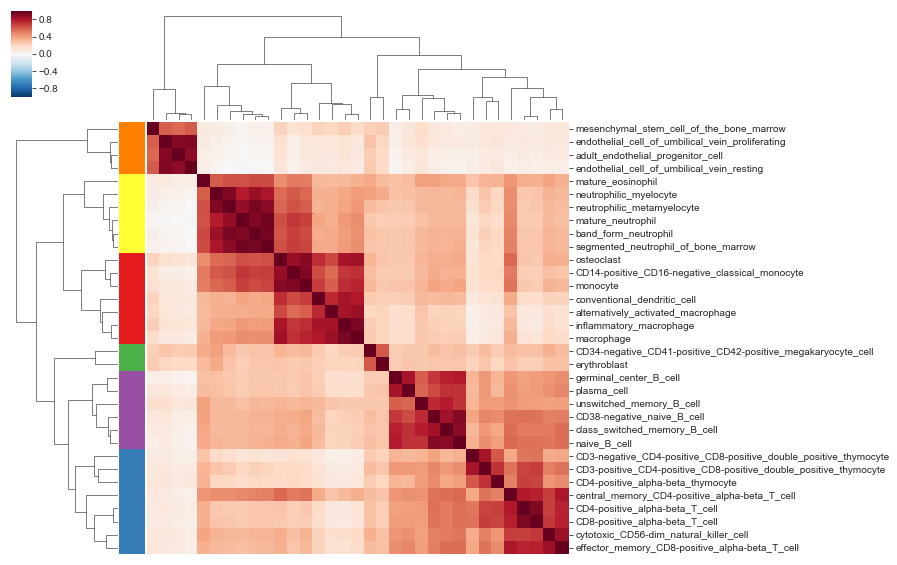

In [8]:
my_corr = df_var.corr()
row_linkage = linkage(pdist(my_corr), method='average')
x = cut_tree(row_linkage, 6).flatten()
pal = sns.color_palette("Set1")
cg = sns.clustermap(my_corr,xticklabels=False, figsize=(10, 10), row_linkage=row_linkage,
                    vmin=-1, vmax=1, cmap="RdBu_r", row_colors=[pal[i % len(pal)] for i in x])

plt.savefig("out/correlation_plot.svg")

# Run maelstrom

Here we use the Python API. The equivalent command-line is:

```
$ gimme maelstrom data/H3K27ac.table.hg38.top50K.tsv.gz hg38 out/maelstrom.out/ -p gimme.vertebrate.v5.0 -N 12
```

The `maelstrom` command will re-use results in the output directory that already exist such as motif counts or results from individual methods.

In [9]:
run_maelstrom(
     "data/H3K27ac.table.hg38.top50K.tsv.gz", 
     "hg38",                                   # FASTA file, or name of genome installed with genomepy
     "out/maelstrom.out",                      # Output directory for maelstrom result files
     pwmfile="gimme.vertebrate.v5.0",
     ncpus=12,                                 # Update with number of cores of your system
) 

2018-11-19 09:11:47,185 - INFO - Starting maelstrom
2018-11-19 09:11:48,138 - INFO - Counts, using: out/maelstrom.out/motif.count.txt.gz
2018-11-19 09:11:48,141 - INFO - Scores, using: out/maelstrom.out/motif.score.txt.gz
2018-11-19 09:12:16,498 - WARNING - bayesianridge output already exists... skipping
2018-11-19 09:12:44,483 - WARNING - xgboost output already exists... skipping
2018-11-19 09:13:11,951 - WARNING - lightningregressor output already exists... skipping
2018-11-19 09:13:39,580 - WARNING - lasso output already exists... skipping
2018-11-19 09:13:39,709 - INFO - Rank aggregation
2018-11-19 09:13:53,090 - INFO - html report
2018-11-19 09:16:43,049 - INFO - out/maelstrom.out/gimme.maelstrom.report.html


In [10]:
!ls out/maelstrom.out/

H3K27ac.table.hg38.top50K.tsv.gz.cluster.txt
activity.bayesianridge.score.out.txt
activity.lasso.score.out.txt
activity.lightningregressor.score.out.txt
activity.xgboost.score.out.txt
final.out.csv
gimme.maelstrom.report.html
gimme.vertebrate.v5.0.motif2factors.txt
gimme.vertebrate.v5.0.pfm
input.table.txt
logos
motif.count.txt.gz
motif.score.txt.gz


In [2]:
# Read the final maelstrom result
df_act = pd.read_table("out/maelstrom.out/final.out.csv", index_col=0, comment="#")

# Read motif to factor mappings
m2f = pd.read_table("out/maelstrom.out/gimme.vertebrate.v5.0.motif2factors.txt", index_col=0,
                   names=["motif", "factor", "evidence", "direct"])
m2f["factor"] = m2f["factor"].str.upper()
g = pd.DataFrame(m2f[["factor"]].reset_index().drop_duplicates().groupby("motif")["factor"].apply(lambda x: ",".join(sorted([y for y in x if not "ENS" in y][:10]))))

# Visualize top motifs

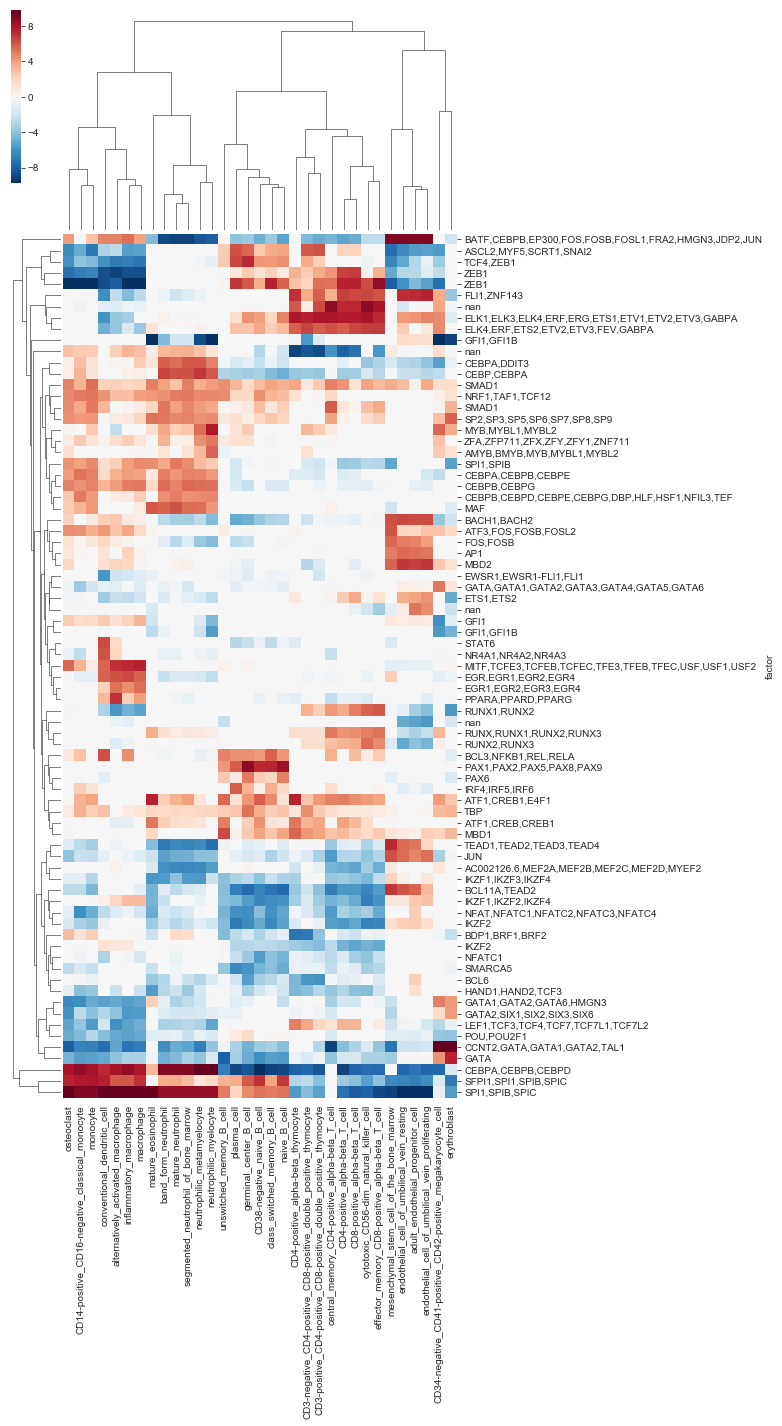

In [12]:
sns.clustermap(df_act[df_act.abs().max(1) >= 5].join(g).set_index("factor"), cmap="RdBu_r",
              figsize=(8,20))

plt.savefig("out/H3K27ac.maelstrom.result.svg")

GM.5.0.Runt.0001:


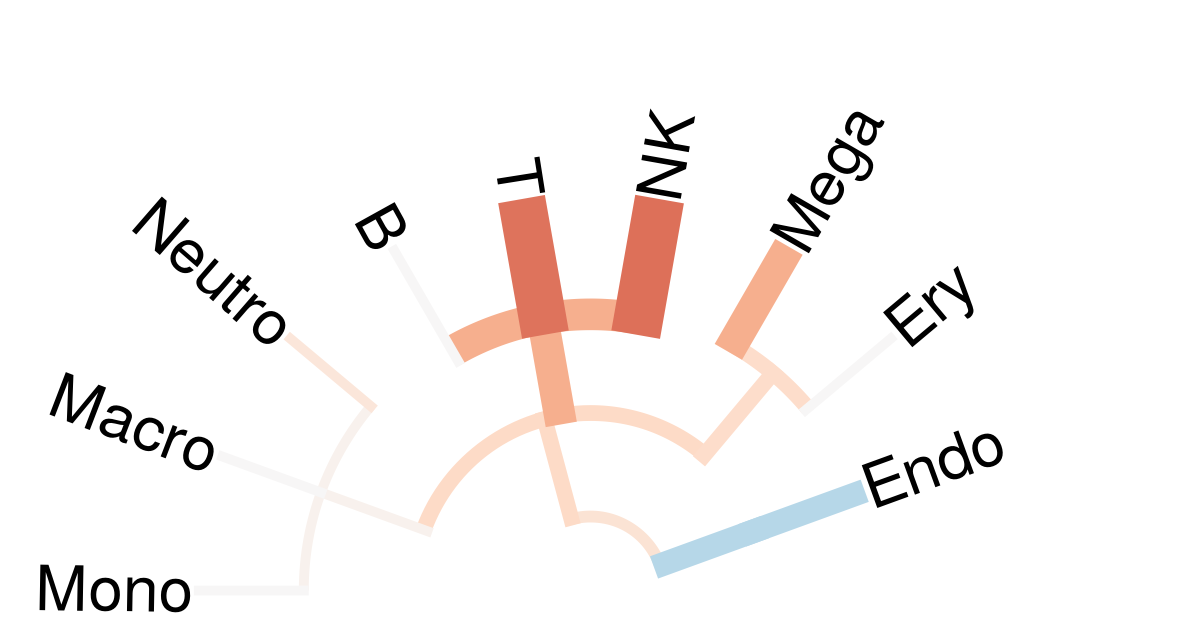

GM.5.0.Homeodomain.0125:


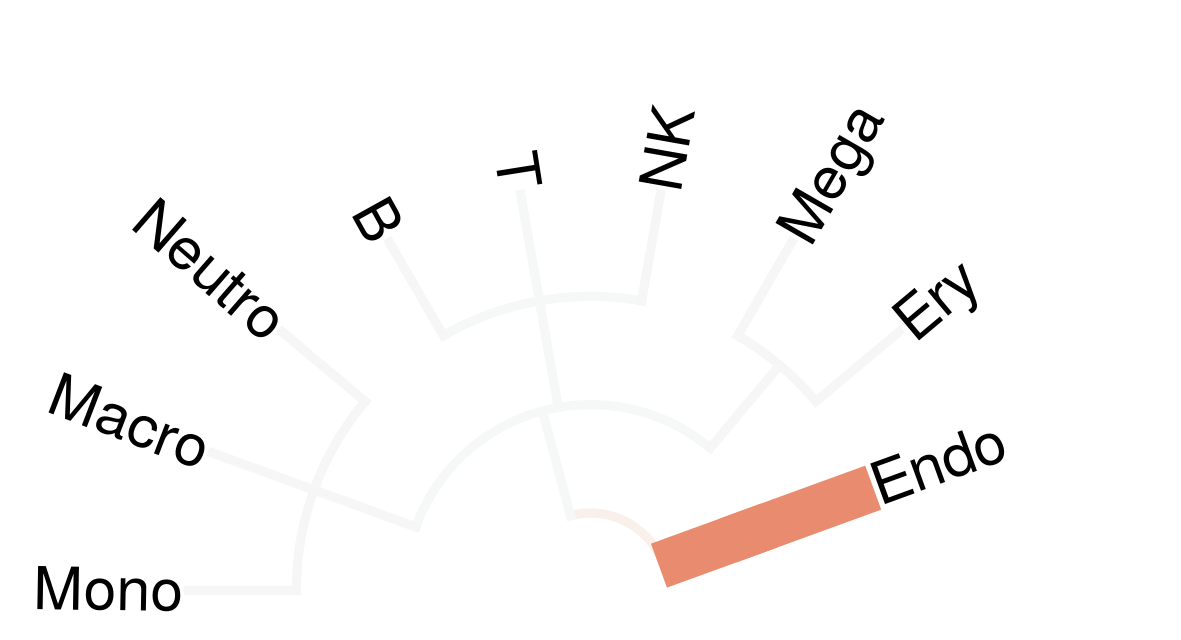

GM.5.0.Ets.0015:


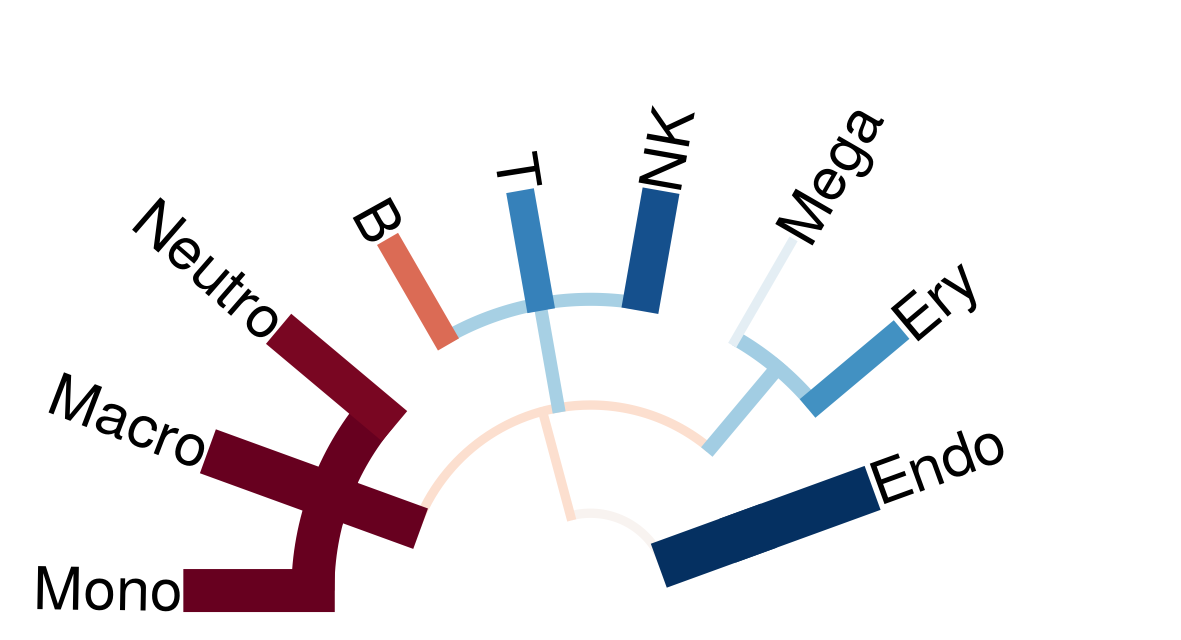

GM.5.0.bZIP.0052:


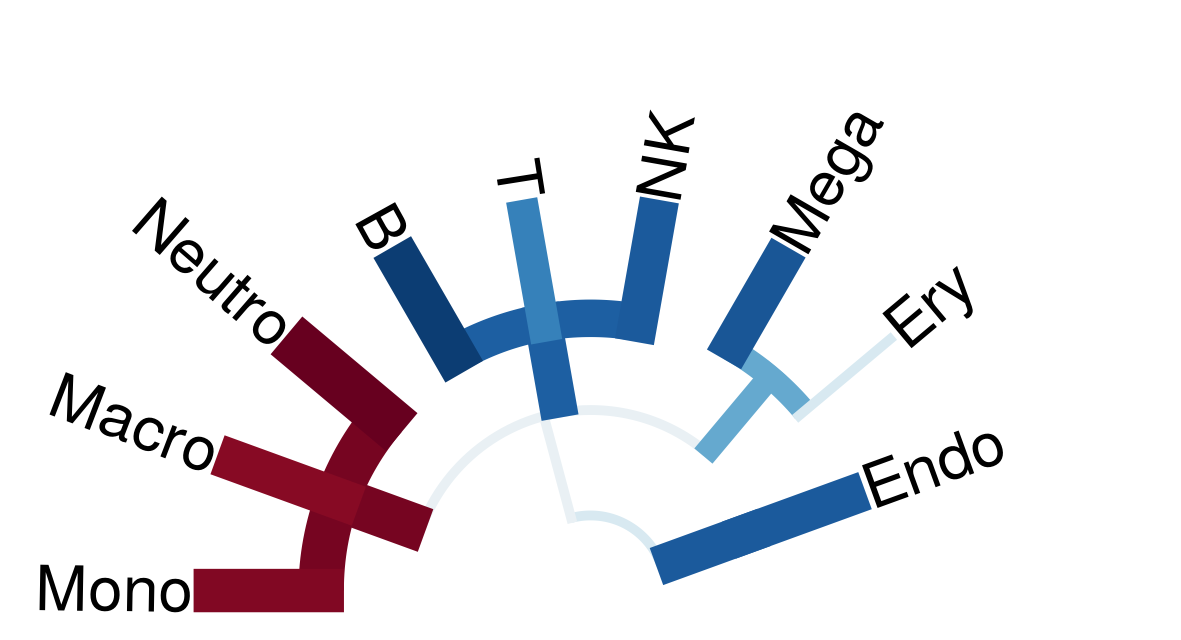

GM.5.0.C2H2_ZF_Homeodomain.0002:


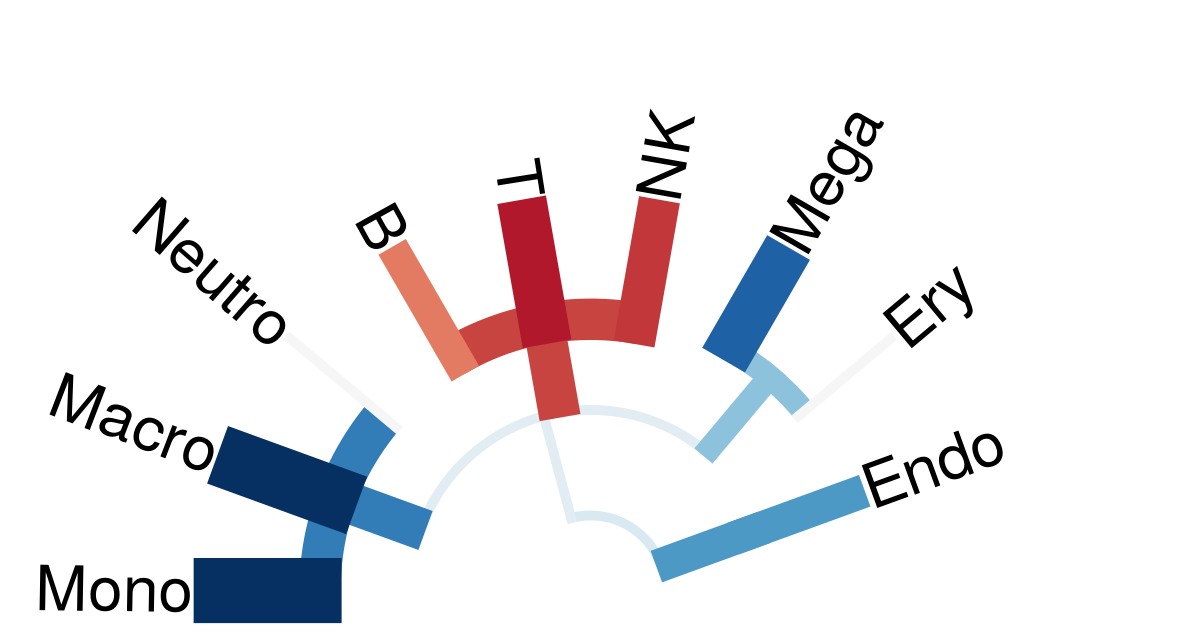

GM.5.0.GATA.0001:


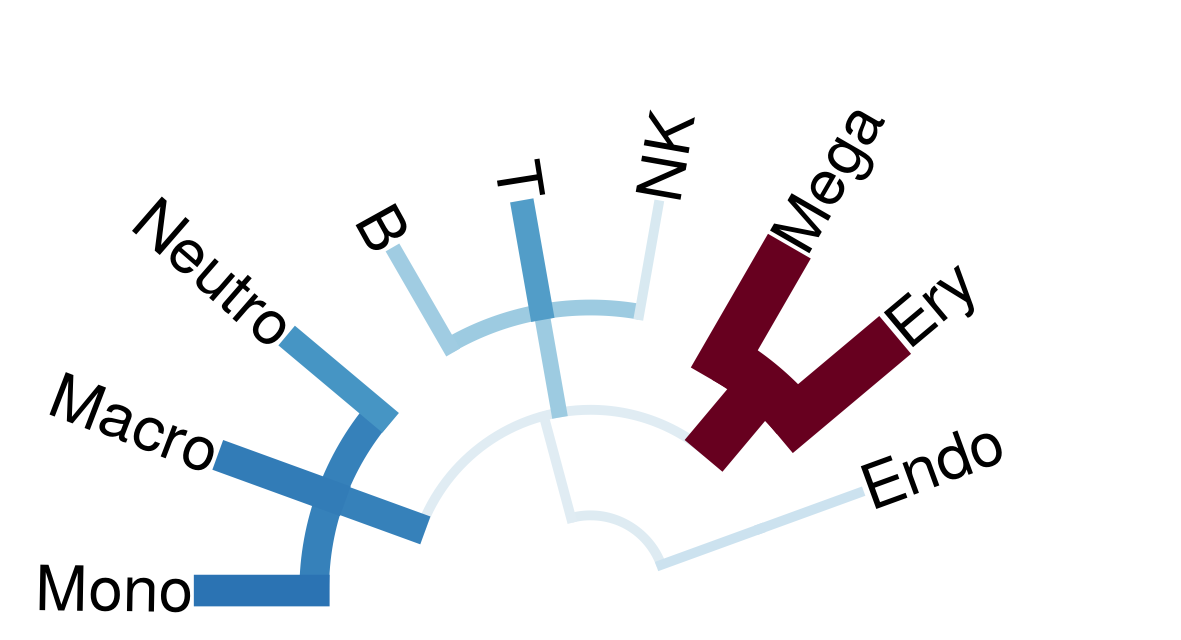

In [3]:
from gimmemotifs.plot import motif_tree_plot
from IPython.display import Image
from IPython.display import display

newick = "(((Mono,Macro,Neutro),(B,T,NK),(Mega, Ery)),(Endo));"

df_act_cp = pd.DataFrame(index=df_act.index)
df_act_cp["Endo"] = df_act.loc[:,df_act.columns.str.contains("endotheli")].mean(1)
df_act_cp["Mono"] = df_act.loc[:,df_act.columns.str.contains("monocyte")].mean(1)
df_act_cp["Macro"] = df_act.loc[:,df_act.columns.str.contains("macrophage")].mean(1)
df_act_cp["Neutro"] = df_act.loc[:,df_act.columns.str.contains("neutrophil")].mean(1)
df_act_cp["B"] = df_act.loc[:,df_act.columns.str.contains("B_cell")].mean(1)
df_act_cp["T"] = df_act.loc[:,df_act.columns.str.contains("T_cell")].mean(1)
df_act_cp["NK"] = df_act.loc[:,df_act.columns.str.contains("natural_killer")].mean(1)
df_act_cp["Mega"] = df_act.loc[:,df_act.columns.str.contains("megakar")].mean(1)
df_act_cp["Ery"] = df_act.loc[:,df_act.columns.str.contains("erythro")].mean(1)


motifs = [
    "GM.5.0.Runt.0001",          # RUNX
    "GM.5.0.Homeodomain.0125",   # NANOG
    "GM.5.0.Ets.0015",           # SPI1
    "GM.5.0.bZIP.0052",          # CEBP
    "GM.5.0.C2H2_ZF_Homeodomain.0002", # ZEB1
    "GM.5.0.GATA.0001",           # GATA1
]


for motif in motifs:
    motif_tree_plot("out/{}.tree.png".format(motif), newick, df_act_cp.loc[motif], vmin=-9, vmax=9)
    print("{}:".format(motif))
    img = Image("out/{}.tree.png".format(motif), width=500)
    display(img, )